In [1]:
#import pandas as pd
#import os

#main_path=r"C:\Users\quilo\Desktop\Data"
#lst_df=[]

#for file in os.listdir(main_path):
 #   if file.startswith("blogData"):
  #      lst_df.append(pd.read_csv(main_path+'/'+ file,header=None))
        
#df=pd.concat(lst_df, axis=0,ignore_index=True)
#df.to_csv('BlogData.csv',index=False,header=True)
        


## Required packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample
from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

In [3]:
def summary_statistics(arr):
    # calculates summary statistics from array
    
    return [np.min(arr),np.max(arr),np.mean(arr), np.std(arr),np.quantile(arr,0.25),np.quantile(arr,0.5),np.quantile(arr,0.75)]

def normalize(arr):
    #Normalize an array so that the sum equals to 1.
    
    soma=0
    
    for i in range(len(arr)):
            soma+=arr[i]
    return arr/soma

def set_1D_intersection(arr1,arr2):
    # Calculate the intersection between two 1D intervals [a,b] [c,d]
    
    r=[] # intersection result
    
    if arr2[0] > arr1[1] or arr1[0]>arr2[1]:
        
        return r
    else:
        r.append(max(arr1[0],arr2[0]))
        r.append(min(arr1[1],arr2[1]))
        
    return r

def set_1D_union(arr1,arr2):
    # Calculates the union between two 1D intervals [a,b] [c,d]
    
    r=[] # union result
    
    r.append(min(arr1[0],arr2[0]))
    r.append(max(arr1[1],arr2[1]))
        
    return r

def intersection_over_union1D(arr1,arr2):
    # Computes the overlap over union. Lies in (0,1)
    
    inter=set_1D_intersection(arr1,arr2)
    union=set_1D_union(arr1,arr2)
    
    if not inter:
        return 0
    
    return ((inter[1]-inter[0])/(union[1]-union[0]))

T=100 # number of trials

lst_results=[] # list to store interval width summary statistics across T trials


lst_coverages=[]  # list to store coverage summary statistics across T trials


plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size': 25})
sns.set_style("darkgrid", {'axes.grid' : True})

In [4]:
#load the data

data=pd.read_csv('BlogData.csv')
print(data.shape)
data.head(10)

(60021, 281)


,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,10.630660,17.882992,1.0,259.0,5.0,4.018276,10.396790,0.0,235.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,43.435825,75.590485,0.0,634.0,20.0,15.998589,44.560870,0.0,473.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.733333,3.043390,0.0,9.0,0.0,0.733333,1.526070,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,27.230215,45.970950,0.0,371.0,14.0,10.784173,24.209942,0.0,228.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,4.500000,6.677075,0.0,18.0,0.5,3.000000,4.000000,0.0,10.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,156.402980,246.055980,0.0,970.0,28.0,76.149254,131.900830,0.0,725.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.0
6,10.509316,36.593983,0.0,191.0,1.0,3.602485,20.633831,0.0,179.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,123.869190,129.566220,0.0,1065.0,87.0,43.328970,62.774147,0.0,491.0,19.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
8,22.463415,42.184900,0.0,188.0,7.5,8.219512,25.020493,0.0,174.0,1.5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
9,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#check if there any missing value
data.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
276    0
277    0
278    0
279    0
280    0
Length: 281, dtype: int64

In [6]:
#drop irrelevant columns and move the target (price) to the last position

#target=data['price'].values # shares

#data = data.drop(columns=['instant','dteday'],axis=1)
#data['cnt']=data['cnt'].astype(np.float64)
#data.insert(data.shape[1], 'price', target)
#data.head(10)

In [7]:
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

# Load boston housing prices dataset
#d=load_boston()
#X=d['data']
#y=d['target']

#Split the dataset in 3 mutually exclusive datasets, train, calibatrion and evaluation (for assessement)

def train_cal_test_split(X,y,random_state=22):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
    X_cal,X_val,y_cal,y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    
    return X_train,y_train,X_cal,y_cal,X_val,y_val

In [8]:
X_train,y_train,X_cal,y_cal,X_val,y_val=train_cal_test_split(X,y)

In [9]:
scaler_X=MinMaxScaler()
X_train=scaler_X.fit_transform(X_train)
X_cal=scaler_X.transform(X_cal)
X_val=scaler_X.transform(X_val)

In [10]:
#quantile loss function

def tilted_loss(q,y,f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted (predicted) value.
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

# Feedforward neural network QR architecture

def QuantileRegressionModel(X_train,y_train,T,qs=[0.05,0.5,0.95],n_layers=2,n_neurons=100,decay_rate=0.5,activation='relu',optimizer='adam',epochs=1000,batch_size=1000,verbose=0):
    # T: # of repetitions
    # qs quantiles to estimate
    # n_layers: number of hidden layers
    # n_neurons: number of neurons per layer (multiplied by decay_rate)
    # activation: activation function
    # optimizer: optimization algorithm
    # epochs: number of times the training set is read in the optimization process
    # batch_size: number of examples seen before updating the weights
    # verbose : ignore or show the outputs during optimization 
    
    models=[]
    
    for i in tqdm(range(T)):

        ipt_layer = Input((X_train.shape[1],))
        layer1 = Dense(n_neurons, activation=activation)(ipt_layer)

        previous_layer=layer1

        for i in range(n_layers):
            next_layer = Dense(max(int((decay_rate**(i+1))*(n_neurons)),1), activation=activation)(previous_layer)
            previous_layer=next_layer

        out1 = Dense(1, name='out1')(previous_layer)
        out2 = Dense(1, name='out2')(previous_layer)
        out3 = Dense(1, name='out3')(previous_layer)

        q1, q2, q3 = qs
        model = Model(inputs=ipt_layer, outputs=[out1, out2, out3])
        model.compile(loss={'out1': lambda y,f: tilted_loss(q1,y,f),
                            'out2': lambda y,f: tilted_loss(q2,y,f),
                            'out3': lambda y,f: tilted_loss(q3,y,f),}, 
                      loss_weights={'out1': 1, 'out2': 1, 'out3': 1},
                     optimizer=optimizer)



        model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        models.append(model)
    
    return models
    

In [11]:
def permutation_importance(model,X_train,y_train,X_cal,y_cal,n_repeats):
    # model: trained ML model
    # X_train: Explanatory variables training set
    # y_train: Response variables for training
    # X_cal: Explanatory variables for evaluation (calculate decrease in importance)
    # y_cal: Response variables for evaluation (calculate decrease in importance)
    # n_repeats: Number of repetitions to shuffle each column and then average the difference
    
    n_features=X_train.shape[1]
    feature_importances=np.zeros((n_repeats,n_features))
    true_indexes = np.arange(n_features)
    
    for j in tqdm(range(n_features)):
        for i in range(n_repeats):
            X_cal_permuted=np.copy(X_cal)
            X_cal_permuted[:,j]=resample(X_cal_permuted[:,j])
            y_pred=model.predict(X_cal)[1].flatten()
            y_pred_permuted=model.predict(X_cal_permuted)[1].flatten()
            mae= mean_absolute_error(y_pred,y_cal)
            mae_perm=mean_absolute_error(y_pred_permuted,y_cal)
            diff=np.abs(mae_perm-mae)
            feature_importances[i,j]= diff
        
    return np.mean(feature_importances,axis=0)

In [12]:
models=QuantileRegressionModel(X_train,y_train,T)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [4:06:50<00:00, 148.11s/it]


In [13]:
feature_importance=permutation_importance(models[0],X_train,y_train,X_cal,y_cal,15)
#feature_importance=normalize(feature_importance)
feature_importance

100%|██████████████████████████████████████████████████████████████████████████████| 280/280 [2:20:18<00:00, 30.07s/it]


array([9.48406791e-02, 6.85205688e-02, 5.63373477e-02, 8.66799848e-01,
       7.96263912e-02, 2.10062907e-01, 6.36274451e-02, 2.69370054e-02,
       4.97312644e-01, 1.77088149e-01, 1.57519378e-01, 1.15985765e-02,
       0.00000000e+00, 7.34597369e-02, 5.05749385e-02, 4.14307298e-02,
       3.66324873e-01, 7.51544352e-02, 3.30019501e-01, 1.01122346e-01,
       8.76440708e-01, 1.76485982e-01, 3.70672629e-02, 5.04385844e-01,
       4.88752382e-03, 1.58767305e-02, 4.86327425e-02, 9.96687230e-04,
       6.22546016e-01, 9.81428371e-02, 6.90849455e-03, 7.20677264e-03,
       0.00000000e+00, 2.57775364e-02, 3.53876821e-01, 1.07741875e-02,
       4.64566318e-02, 0.00000000e+00, 5.22375035e-02, 8.44926154e-03,
       6.08358093e-02, 5.04592088e-02, 2.68265956e-03, 1.85662993e-01,
       2.50574305e-01, 3.73875159e-02, 5.28503420e-02, 9.97812018e-02,
       6.78040403e-02, 4.52113656e-04, 7.08015714e-01, 1.21109066e+00,
       1.58670950e-01, 1.27685187e+00, 1.18573016e-02, 2.02428876e-02,
      

### Naive Inductive Conformal Prediction Regression steps

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Define the score function as $s(x,y)= |f(x)-y|$
3. For every $(x_i,y_i) \in D_{cal}$, compute $s_i=s(x_i,y_i)$, where $D_{cal}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal}}$ is the calibration data set.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_i)- \hat{q},f(x_i)+ \hat{q}]
\end{equation}

**Problem:** This guarantees coverage property, however, the forecast interval dimension is independent of x and its dimension is allways $2\hat{q}$.




In [14]:
def calculate_q_yhat_naive(models,X_cal,y_cal,T,alpha=0.1):
    # Calculate T q_yhats, one per each trial
    
    q_yhat_T_runs=[]
    
    
    for i in range(T):
        f_cal=models[i].predict(X_cal)
        y_pred=f_cal[1].flatten()
        N=len(y_cal)
        q_yhat=np.quantile(np.abs(y_cal-y_pred),np.ceil((N+1)*(1-alpha))/N)
        q_yhat_T_runs.append(q_yhat)
    
    return q_yhat_T_runs,np.mean(q_yhat_T_runs),models

In [15]:
q_yhat_T_runs,q_yhat_mean,models=calculate_q_yhat_naive(models,X_cal,y_cal,T,alpha=0.1)

In [16]:
lst_results.append(summary_statistics(q_yhat_T_runs))

In [17]:
models[0].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 280)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          28100       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 50)           5050        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 25)           1275        ['dense_1[0][0]']                
                                                                                              

In [18]:
q_yhat_mean

8.761451237286616

In [19]:
def calculate_performance(lower_bound,upper_bound,y_true,y_pred,alpha=0.1):
    #calculate coverage
    
    out_of_bounds=0
    N=len(y_true)
    
    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bounds+=1
        
    
    
    return 1-out_of_bounds/N


In [20]:
coverages=np.zeros(T)

for i in range(T):
    f_val=models[i].predict(X_val)[1].flatten()
    coverages[i]=calculate_performance(f_val-q_yhat_T_runs[i],f_val+q_yhat_T_runs[i],y_val,f_val)
    print('Iteration '+str(i+1),' with a coverage of {}'.format(coverages[i]))

lst_coverages.append(summary_statistics(coverages))



print('Median coverage of {}'.format(np.median(coverages)))

Iteration 1  with a coverage of 0.9079035052645609
Iteration 2  with a coverage of 0.9014394242303079
Iteration 3  with a coverage of 0.9015060642409702
Iteration 4  with a coverage of 0.9053711848593896
Iteration 5  with a coverage of 0.9028388644542183
Iteration 6  with a coverage of 0.9019725443156071
Iteration 7  with a coverage of 0.9048380647740903
Iteration 8  with a coverage of 0.9053045448487271
Iteration 9  with a coverage of 0.9049047047847527
Iteration 10  with a coverage of 0.9039717446354791
Iteration 11  with a coverage of 0.9053711848593896
Iteration 12  with a coverage of 0.9046381447421031
Iteration 13  with a coverage of 0.9039051046248168
Iteration 14  with a coverage of 0.9038384646141543
Iteration 15  with a coverage of 0.9038384646141543
Iteration 16  with a coverage of 0.9029055044648807
Iteration 17  with a coverage of 0.9026389444222311
Iteration 18  with a coverage of 0.9012395041983207
Iteration 19  with a coverage of 0.904105024656804
Iteration 20  with a c

### Conformalized Quantile Regression

Solution for the foregoing problem: **Quantile Regression** <br>

Quantile regression algorithm attempts to learn the $\alpha \in (0,1)$ quantile of $Y_{test}|X_{test} = x$ for each possible value of x.
For that purpose. we shall use the quantile loss, also known as pinball loss.


**Problem:** We only get a estimate of the real quantiles $\left[\hat{Q}_{\frac{\alpha}{2}}(x),\hat{Q}_{1-\frac{\alpha}{2}}(x)\right]$. Although this provides good coverage, it doesn't guarantee $1-\alpha$ coverage.

**Solution:** Conformalize it with s given by
$$s(x,y)=max\left(\hat{Q}_{\frac{\alpha}{2}}(x)-y,y-\hat{Q}_{1-\frac{\alpha}{2}}(x)\right)$$
* Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_2} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.

* Predict with $1-\alpha$ confidence as
\begin{equation}
\left[\hat{Q}_{\frac{\alpha}{2}}(x)-\hat{q},\hat{Q}_{1-\frac{\alpha}{2}}(x)+\hat{q} \right]
\end{equation}

In [21]:
coverages=np.zeros(T)
interval_widths=[]

for i in range(T):
    f_val=models[i].predict(X_val)
    lower_bound=f_val[0].flatten()
    upper_bound=f_val[2].flatten()
    y_pred=f_val[1].flatten()
    interval_widths.append(np.abs(upper_bound-lower_bound))
    coverages[i]=calculate_performance(lower_bound,upper_bound,y_val,y_pred)
    print('Iteration '+str(i+1),' with a coverage of '+ str(coverages[i]),' and a median width of '+str(np.median(interval_widths[i])))

lst_coverages.append(summary_statistics(coverages))

print('Median QR coverage without conformal of '+ str(np.median(coverages))+ ' and a median width of '+str(np.median(interval_widths)))

Iteration 1  with a coverage of 0.4617486338797814  and a median width of 2.4524977
Iteration 2  with a coverage of 0.7915500466480074  and a median width of 1.9917126
Iteration 3  with a coverage of 0.7992136478741837  and a median width of 2.0084786
Iteration 4  with a coverage of 0.7904171664667466  and a median width of 2.138214
Iteration 5  with a coverage of 0.7085832333733173  and a median width of 2.0102432
Iteration 6  with a coverage of 0.7724910035985606  and a median width of 2.1718006
Iteration 7  with a coverage of 0.47920831667333064  and a median width of 2.2623901
Iteration 8  with a coverage of 0.7995468479274956  and a median width of 2.0805507
Iteration 9  with a coverage of 0.7563641210182593  and a median width of 1.7885009
Iteration 10  with a coverage of 0.8179394908703186  and a median width of 2.1335783
Iteration 11  with a coverage of 0.7617619618819139  and a median width of 2.0798507
Iteration 12  with a coverage of 0.6447421031587365  and a median width of

Iteration 98  with a coverage of 0.8068106090896975  and a median width of 2.3093905
Iteration 99  with a coverage of 0.7837531654005064  and a median width of 1.987186
Iteration 100  with a coverage of 0.7834199653471945  and a median width of 2.2564003
Median QR coverage without conformal of 0.7781554045048646 and a median width of 2.1615543


In [22]:
interval_widths_naive=np.array(interval_widths).flatten()

In [23]:
lst_results.append(summary_statistics(np.array(interval_widths).flatten()))

In [24]:
mu=np.mean(interval_widths)
sigma=np.std(interval_widths)
print(mu,sigma)

6.128766 18.304546


In [25]:
np.median(interval_widths)

2.1615543

### Calibration step (QR)

In [26]:
def calibrate_qyhat(y_true,lower_bound,upper_bound,alpha=0.1):
    # Calculate q_yhat for QR (CQR)
    
    N=len(y_true)
    s=np.amax([lower_bound-y_true,y_true-upper_bound],axis=0)
    q_yhat=np.quantile(s,np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat

q_yhats=np.zeros(T)
interval_widths=[]
coverages=np.zeros(T)

for i in range(T):
    forecast=models[i].predict(X_cal)
    lower_bound=forecast[0].flatten()
    upper_bound=forecast[2].flatten()

    q_yhat=calibrate_qyhat(y_cal,lower_bound,upper_bound)
    q_yhats[i]=q_yhat
    forecast=models[i].predict(X_val)
    lower_bound=forecast[0].flatten()-q_yhat
    upper_bound=forecast[2].flatten()+q_yhat
    y_pred=forecast[1].flatten()
    interval_widths.append(np.abs(upper_bound-lower_bound))
    coverages[i]=calculate_performance(lower_bound,upper_bound,y_val,y_pred)
    print('Iteration '+str(i+1),' with a coverage of '+ str(coverages[i]),' and a median width of '+str(np.median(interval_widths[i])))

lst_coverages.append(summary_statistics(coverages))
lst_results.append(summary_statistics(np.array(interval_widths).flatten()))

print('Median CQR coverage without conformal of '+ str(np.median(coverages))+ ' and a median width of '+str(np.median(interval_widths)))

Iteration 1  with a coverage of 0.9081700653072105  and a median width of 11.171395
Iteration 2  with a coverage of 0.900639744102359  and a median width of 9.362588
Iteration 3  with a coverage of 0.9026389444222311  and a median width of 7.4757166
Iteration 4  with a coverage of 0.9023057443689191  and a median width of 9.566725
Iteration 5  with a coverage of 0.9039051046248168  and a median width of 6.561061
Iteration 6  with a coverage of 0.9011062241769958  and a median width of 11.005983
Iteration 7  with a coverage of 0.9011728641876583  and a median width of 9.688153
Iteration 8  with a coverage of 0.9019059043049447  and a median width of 8.532686
Iteration 9  with a coverage of 0.9032387045181928  and a median width of 7.0907087
Iteration 10  with a coverage of 0.9019725443156071  and a median width of 8.230426
Iteration 11  with a coverage of 0.9039051046248168  and a median width of 9.213699
Iteration 12  with a coverage of 0.9044382247101159  and a median width of 9.92240

Iteration 99  with a coverage of 0.9050379848060776  and a median width of 10.144213
Iteration 100  with a coverage of 0.9017059842729575  and a median width of 10.426248
Median CQR coverage without conformal of 0.9020391843262695 and a median width of 9.563936


### Improved conformalized quantile regression (ICQR)

In [27]:
def optimized_kmeans(X,desired_variance,feature_importance,max_number_of_clusters):
    
    scores=[]
    
    mean_point=np.mean(X,axis=0)
    SSE=np.sum((X-mean_point)**2)
    i=1
    variance=0
    
    while variance < desired_variance and i< max_number_of_clusters:
        km =  KMeans(n_clusters=i+1, random_state=0).fit(X*feature_importance)
        centroids=km.cluster_centers_
        
        clusters=km.labels_
        
        SSE_between=0
        
        for j in range(len(np.unique(clusters))):
            n_k=X[clusters==j,:].shape[0]
            diff=(centroids[j]-mean_point)
            
            SSE_between+=n_k*np.dot(diff,diff)
        
        variance=SSE_between/SSE
        
        scores.append([i+1,variance])
        i+=1
    
    scores=np.array(scores)
    
    best_k=i
    plt.axvline(x=best_k, color='r', linestyle='--')
    plt.plot(scores[:,0],scores[:,1])
    plt.show()
    
    km =  KMeans(n_clusters=i, random_state=0).fit(X*feature_importance)
    
    return km,best_k

In [28]:
def CQR_qyhats_per_group(models,X_train,y_train,X_cal,y_cal,desired_variance,max_number_of_clusters,T,feature_importance,alpha=0.1):
    
    #models=QuantileRegressionModel(X_train,y_train,T)
    km,best_k=optimized_kmeans(X_train,desired_variance,feature_importance,max_number_of_clusters)
    q_yhats_T_runs=np.zeros((T,best_k))
    
    for j in tqdm(range(T)):
        
        f_cal=models[j].predict(X_cal)
        f_cal_upper=f_cal[2].flatten()
        f_cal_lower=f_cal[0].flatten()

        q_yhats=np.zeros(best_k)
        nrows=X_cal.shape[0]
        clusters=km.predict(X_cal*feature_importance)
        
        scores=[]

        for i in range(best_k):
            scores.append([])

        for i in range(nrows):
            scores[clusters[i]].append(max(f_cal_lower[i]-y_cal[i],y_cal[i]-f_cal_upper[i]))


        for i in range(best_k):
            N=len(scores[i])
            q_yhats[i]=np.quantile(scores[i],min(np.ceil((N+1)*(1-alpha))/N,1))
        
        q_yhats_T_runs[j,:]= q_yhats
    
    return models,q_yhats_T_runs,km

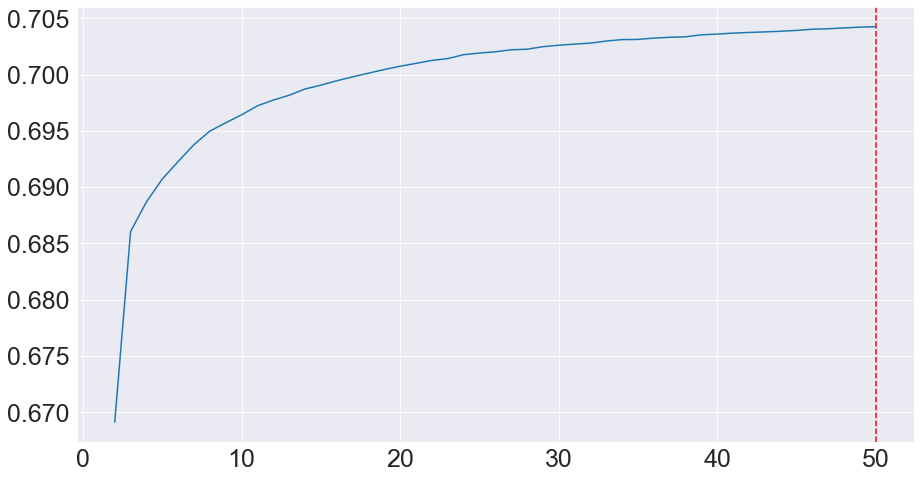

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


In [29]:
models,q_yhats_T_runs,km=CQR_qyhats_per_group(models,X_train,y_train,X_cal,y_cal,0.9,50,T,feature_importance)

In [30]:
np.mean(q_yhats_T_runs,axis=0)

array([ 1.76383899e+00,  6.88457332e-01,  2.97286534e+00,  7.01126256e+00,
        2.95017044e+01,  5.68670696e-03,  2.46387995e+02,  2.14030362e+01,
        2.74341436e+00, -2.87273406e-03,  8.32970567e-01,  4.99124589e-02,
        6.61777498e+00, -3.82492849e-03,  7.15640376e-01,  1.11433291e+02,
        5.47240057e+00,  3.58165074e-02,  1.14067945e-03,  3.94423136e+00,
        2.44194814e+01,  9.59829672e-03,  8.48248890e-02,  8.93214789e+01,
        7.59001441e-01,  7.85481018e+00,  6.14737349e+01, -1.20869382e-03,
        2.69684497e+00,  2.16808015e-03,  3.06902470e+00,  2.20174231e-02,
        5.71852484e-01,  1.71007129e+01,  1.01662619e+02,  4.47383581e-01,
        2.19481866e+00,  4.09167433e-01,  6.76575096e+01,  1.69922611e+00,
       -5.25595786e-04,  1.50881578e+02,  1.25605631e-02,  1.16615317e+01,
        4.67657492e+01,  3.33435430e+02,  3.24055216e-01,  2.09241050e+00,
        1.28085051e+00,  1.35439710e+00])

In [31]:
def ConditionalCQR_calculate_bounds(model,q_yhats,km,X_val,y_val,feature_importance):
    
    f_val=model.predict(X_val)
    f_val_upper=f_val[2].flatten()
    f_val_lower=f_val[0].flatten()
    
    nrows=X_val.shape[0]
    lower_bound=np.zeros(nrows)
    upper_bound=np.zeros(nrows)
    assigned_cluster=km.predict(X_val*feature_importance)
    
    for i in range(nrows):
        lower_bound[i]=f_val_lower[i]-q_yhats[assigned_cluster[i]]
        upper_bound[i]=f_val_upper[i]+q_yhats[assigned_cluster[i]]
        

            
    return lower_bound,upper_bound,f_val[1].flatten()

In [32]:
q_yhats_T_runs.shape

(100, 50)

In [33]:
interval_widths=[]
coverages=np.zeros(T)

for i in range(T):
    lower_bound,upper_bound,y_pred=ConditionalCQR_calculate_bounds(models[i],q_yhats_T_runs[i],km,X_val,y_val,feature_importance)
    coverages[i]=calculate_performance(lower_bound,upper_bound,y_val,y_pred)
    interval_widths.append(np.abs(upper_bound-lower_bound))
    print('Iteration '+str(i+1),' with a coverage of '+ str(coverages[i]),' and a median width of '+str(np.median(interval_widths[i])))

lst_coverages.append(summary_statistics(coverages))
lst_results.append(summary_statistics(np.array(interval_widths).flatten()))

print('Median ICQR coverage without conformal of '+ str(np.median(coverages))+ ' and a median width of '+str(np.median(interval_widths)))

Iteration 1  with a coverage of 0.9053711848593896  and a median width of 5.3114511688969746
Iteration 2  with a coverage of 0.9008396641343462  and a median width of 4.487515948110498
Iteration 3  with a coverage of 0.9035719045715047  and a median width of 3.7650299472388404
Iteration 4  with a coverage of 0.904771424763428  and a median width of 5.004775178964662
Iteration 5  with a coverage of 0.9053711848593896  and a median width of 4.707958666702906
Iteration 6  with a coverage of 0.9013727842196455  and a median width of 5.096408075777263
Iteration 7  with a coverage of 0.9075036652005865  and a median width of 4.631197035954942
Iteration 8  with a coverage of 0.9017726242836199  and a median width of 4.321917329499804
Iteration 9  with a coverage of 0.9043049446887912  and a median width of 3.9936143057997953
Iteration 10  with a coverage of 0.9039717446354791  and a median width of 4.015644610450602
Iteration 11  with a coverage of 0.9037718246034919  and a median width of 4.

Iteration 90  with a coverage of 0.9013727842196455  and a median width of 4.855726005448645
Iteration 91  with a coverage of 0.9032387045181928  and a median width of 5.084139015834084
Iteration 92  with a coverage of 0.9035052645608423  and a median width of 5.788468703843596
Iteration 93  with a coverage of 0.9020391843262695  and a median width of 4.9896501675664195
Iteration 94  with a coverage of 0.9028388644542183  and a median width of 4.384603469134245
Iteration 95  with a coverage of 0.9028388644542183  and a median width of 5.603641216338686
Iteration 96  with a coverage of 0.9079035052645609  and a median width of 5.729336953037237
Iteration 97  with a coverage of 0.9029055044648807  and a median width of 5.529218311516859
Iteration 98  with a coverage of 0.9003731840597095  and a median width of 4.207625023425758
Iteration 99  with a coverage of 0.8979075036652006  and a median width of 4.4054507533112215
Iteration 100  with a coverage of 0.904105024656804  and a median wi

In [34]:
df_width_results=pd.DataFrame(lst_results,columns=['min','max','mean','std','Q1','median','Q3'])
df_width_results

,min,max,mean,std,Q1,median,Q3
0,8.004139,10.125463,8.761451,0.449065,8.459326,8.705840,8.989208
1,0.000005,1466.360840,6.128766,18.304546,1.146352,2.161554,4.860748
2,0.002618,1471.915527,12.929808,18.287203,8.002523,9.563936,12.044697
3,0.000032,1591.786651,26.131895,75.863576,1.823785,4.647387,14.873668


In [35]:
print(df_width_results.to_latex(index=False)) 

\begin{tabular}{rrrrrrr}
\toprule
     min &         max &      mean &       std &       Q1 &   median &        Q3 \\
\midrule
8.004139 &   10.125463 &  8.761451 &  0.449065 & 8.459326 & 8.705840 &  8.989208 \\
0.000005 & 1466.360840 &  6.128766 & 18.304546 & 1.146352 & 2.161554 &  4.860748 \\
0.002618 & 1471.915527 & 12.929808 & 18.287203 & 8.002523 & 9.563936 & 12.044697 \\
0.000032 & 1591.786651 & 26.131895 & 75.863576 & 1.823785 & 4.647387 & 14.873668 \\
\bottomrule
\end{tabular}



In [36]:
df_coverages=pd.DataFrame(lst_coverages,columns=['min','max','mean','std','Q1','median','Q3'])
df_coverages

,min,max,mean,std,Q1,median,Q3
0,0.897974,0.908103,0.903519,0.001878,0.902106,0.903539,0.904655
1,0.391443,0.867453,0.750877,0.089328,0.760063,0.778155,0.791700
2,0.898241,0.908170,0.902397,0.001920,0.901090,0.902039,0.903772
3,0.897908,0.911769,0.903157,0.002276,0.901623,0.903105,0.904172


In [37]:
print(df_coverages.to_latex(index=False)) 

\begin{tabular}{rrrrrrr}
\toprule
     min &      max &     mean &      std &       Q1 &   median &       Q3 \\
\midrule
0.897974 & 0.908103 & 0.903519 & 0.001878 & 0.902106 & 0.903539 & 0.904655 \\
0.391443 & 0.867453 & 0.750877 & 0.089328 & 0.760063 & 0.778155 & 0.791700 \\
0.898241 & 0.908170 & 0.902397 & 0.001920 & 0.901090 & 0.902039 & 0.903772 \\
0.897908 & 0.911769 & 0.903157 & 0.002276 & 0.901623 & 0.903105 & 0.904172 \\
\bottomrule
\end{tabular}

